#### Copyright 2019 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# OpenCV

[OpenCV](https://opencv.org/) is an Open Source computer vision library. It comes packaged with many powerful computer vision tools, including image and video processing utilities. The library overlaps somewhat with the Python Image Library, PIL, but also includes some computer vision support that PIL doesn't include.

We'll learn some basics of OpenCV for image processing in this workshop.

## Overview

### Learning Objectives

* Load an image with OpenCV.
* Change the color encoding of an image.
* Modify the size, cropping, and orientation of an image.

### Prerequisites

* Image Manipulation with Python

### Estimated Duration

60 minutes

### Grading Criteria

Each exercise is worth 3 points. The rubric for calculating those points is:

| Points | Description |
|--------|-------------|
| 0      | No attempt at exercise |
| 1      | Attempted exercise, but code does not run |
| 2      | Attempted exercise, code runs, but produces incorrect answer |
| 3      | Exercise completed successfully |

There are 2 exercises in this Colab so there are 6 points available. The grading scale will be N points.

## Load an Image

### Image Loading

Loading an image with OpenCV is easy. Start by downloading a small (640x360) version of [this image of a car](https://pixabay.com/illustrations/car-sports-car-racing-car-speed-49278/) from Pixabay and then uploading it to this colab.

Either save the image as 'car.jpg' or change the `image_file` variable below to the name of the image file.

**Be sure to load the small 640x360 version of the image for this lab.**

After loading the image we can use Matplotlib to view the image.

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt

image_file = 'car.jpg'

image = cv.imread(image_file)

plt.imshow(image)
plt.show()

<Figure size 640x480 with 1 Axes>

### Color Ordering

Does something look off there?

Wasn't the car red when we downloaded the image?

OpenCV assumes the image is stored with blue-green-red (BGR) encoding instead of [red-green-blue (RGB)](https://en.wikipedia.org/wiki/RGB_color_model), but matplotlib assumes RBG so the reds and blues in the image are inverted when displayed.

Why does OpenCV assume images are BGR?

BGR was a historically popular storage format used by digital camera manufacturers and many software packages. At the time it was a good choice for a default. Defaults are difficult to change, so BGR is here to stay in OpenCV.

It doesn't really matter which format is used as long as the inputs to our model are consistent. However, it can be annoying to look at images with unnatural colors.

Luckily it is easy to change from BGR to RGB, just use `cvtColor`. There are [scores of conversions](https://docs.opencv.org/3.1.0/d7/d1b/group__imgproc__misc.html) possible.

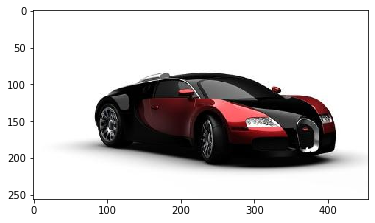

In [3]:
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

## Cropping With Edge Detection

Another strategy is to crop the image using "edge detection" and then scale the image after you have cropped it down.

This strategy can be error-prone, but it can also be really helpful in isolating individual objects in an image.

In the case of the car image that we have loaded, cropping based on edge detection is both easy and effective. In image with more noise in the background automatic cropping will be much more difficult.

To begin cropping we'll rely on the [Canny](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny) detection algorithm.

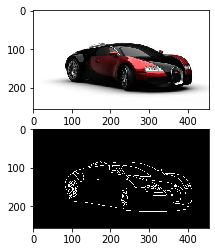

In [4]:
threshold = 200
edges = cv.Canny(image, threshold, threshold*2)

fig, (orig, edge) = plt.subplots(2)
orig.imshow(image, cmap='gray')
edge.imshow(edges, cmap='gray')
plt.show()

What is that 'threshold' setting? It is a parameter that is set by tuning values to the images that you are processing. More details can be found at the [Wikipedia article about Canny](https://en.wikipedia.org/wiki/Canny_edge_detector).

Let's see a few different thresholds in action.

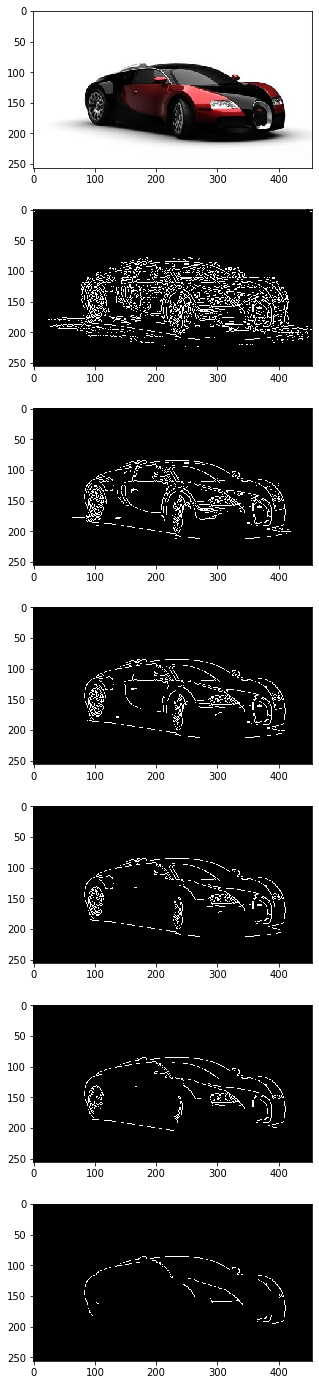

In [5]:
fig, (orig, t1, t50, t100, t200, t300, t500) = plt.subplots(7, figsize=(5,25))

orig.imshow(image)
t1.imshow(cv.Canny(image, 10, 10*2), cmap='gray')
t50.imshow(cv.Canny(image, 50, 50*2), cmap='gray')
t100.imshow(cv.Canny(image, 100, 100*2), cmap='gray')
t200.imshow(cv.Canny(image, 200, 200*2), cmap='gray')
t300.imshow(cv.Canny(image, 300, 300*2), cmap='gray')
t500.imshow(cv.Canny(image, 500, 500*2), cmap='gray')
plt.show()

None of these settings do too badly, though a threshold of 10 has a lot of noise and a threshold of 500 barely outlines the car.

we have to remember that our goal is to build a bounding box around the car and crop on that bounding box.

Another consideration is that the edge detection algorithm is often more effective if the image is grayscale and if there is some blurring.
 
First, convert the image to grayscale.

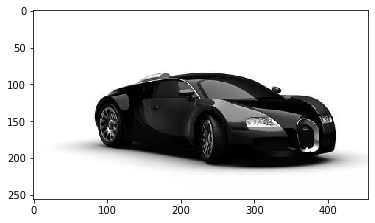

In [6]:
img_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap='gray')

And now blur the image a bit.

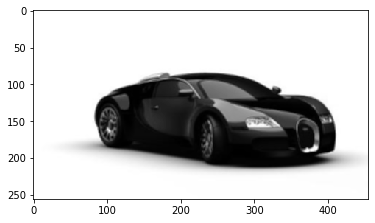

In [7]:
img_gray = cv.blur(img_gray, (3,3))
plt.imshow(img_gray, cmap='gray')

Given this new grayscale and blurred image, we can run the edge detection algorithm again.

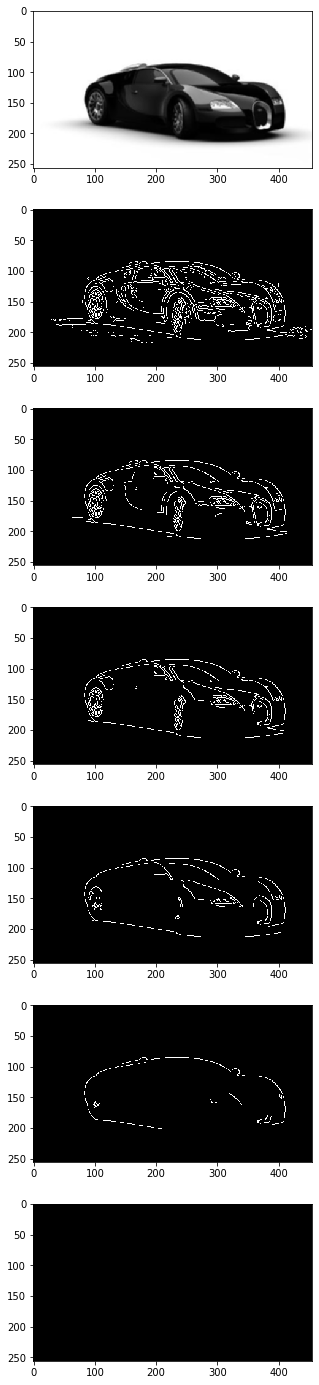

In [8]:
fig, (orig, t1, t50, t100, t200, t300, t500) = plt.subplots(7, figsize=(5,25))

orig.imshow(img_gray, cmap='gray')
t1.imshow(cv.Canny(img_gray, 10, 10*2), cmap='gray')
t50.imshow(cv.Canny(img_gray, 50, 50*2), cmap='gray')
t100.imshow(cv.Canny(img_gray, 100, 100*2), cmap='gray')
t200.imshow(cv.Canny(img_gray, 200, 200*2), cmap='gray')
t300.imshow(cv.Canny(img_gray, 300, 300*2), cmap='gray')
t500.imshow(cv.Canny(img_gray, 500, 500*2), cmap='gray')
plt.show()

The threshold of 200 seemed to perform reasonably well in both situations, so let's stick with that.

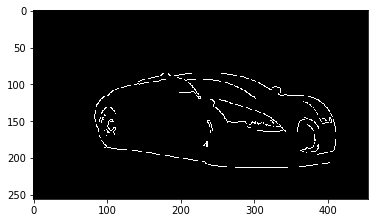

In [9]:
img_canny = cv.Canny(img_gray, 200, 200*2)

plt.imshow(img_canny, cmap='gray')
plt.show()

We now need to find the bounding box around the item in the image that we want to crop. The first step in doing this is utilizing the [findContours](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a) function in OpenCV. This function returns a list of contours found in the output of the Canny algorithm. The contours are defined by lists of x,y values.

In [14]:
contours,_ = cv.findContours(
    img_canny, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)


Given contours, we can approximate the polygon that the contour forms and then create a bounding box around each contour.

In [15]:
bounding_boxes = []
contours_poly = []

for contour in contours:
    polygon = cv.approxPolyDP(contour, 3, True)
    contours_poly.append(polygon)
    bounding_boxes.append(cv.boundingRect(polygon))

print(len(contours_poly))
print(len(bounding_boxes))
print(bounding_boxes)

22
22
[(231, 178, 7, 7), (366, 154, 18, 36), (312, 151, 11, 6), (293, 150, 18, 6), (322, 149, 7, 6), (237, 149, 7, 17), (359, 148, 11, 17), (97, 148, 16, 22), (101, 158, 3, 8), (393, 146, 6, 4), (402, 145, 4, 8), (403, 146, 2, 7), (363, 145, 26, 47), (388, 144, 14, 10), (90, 131, 23, 21), (367, 123, 20, 19), (249, 120, 94, 45), (240, 120, 84, 41), (198, 98, 30, 22), (83, 93, 321, 121), (195, 91, 109, 30), (143, 85, 269, 112)]


Now we have to decide how to crop the image. For this simple example with an image with little-to-no noise in the background, we'll find the largest bounding box and crop to it.
 
First, we need to find the largest bounding box in the list of bounding boxes.

In [16]:
largest_box = None
largest_area = 0

for box in bounding_boxes:
    x, y, width, height = box
    area = height * width
    if area > largest_area:
        largest_area = area
        largest_box = box

print(largest_area)
print(largest_box)

38841
(83, 93, 321, 121)


Now that we have a bounding box, let's draw that box over a copy of the image to see if it captures the car.

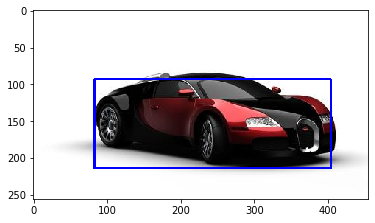

In [17]:
import numpy as np

image_copy = np.copy(image)

x, y, width, height = largest_box
cv.rectangle(image_copy, 
             (x, y),
             (x+width, y+height),
             [0, 0, 255],
             2)

plt.imshow(image_copy)

Not bad. The box does clip the car a bit, but for the most part the car is within the box.

Now we need to crop the image to just the car. To do that we can use regular slicing of NumPy arrays.

Notice that we pair the `x` coordinate with `height` and the `y` with `width`. This is because we want all of the rows for a given height and the columns for a given width.

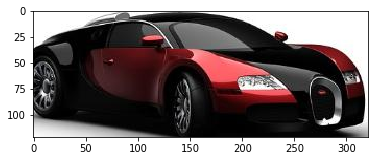

In [18]:
x, y, width, height = largest_box
cropped_img = image[x:x+height, y:y+width]
plt.imshow(cropped_img)

Now we need to make the image into a square by padding the image. To do that we find the longest side and then pad the shorter side with the necessary pixels to make the image a square.

To add the padding we use OpenCV's `copyMakeBorder` function.

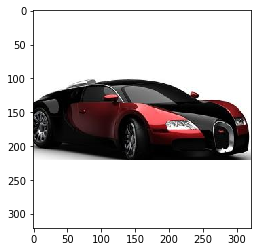

In [19]:
height = cropped_img.shape[0]
width = cropped_img.shape[1]

left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0
if height > width:
    left_pad = int((height-width) / 2)
    right_pad = height-width-left_pad
elif width > height:
    top_pad = int((width-height) / 2)
    bottom_pad = width-height-top_pad

img_square = cv.copyMakeBorder(
    cropped_img,
    top_pad,
    bottom_pad,
    left_pad,
    right_pad,
    cv.BORDER_CONSTANT,
    value=(255,255,255))
plt.imshow(img_square)

And finally we can scale the image down to a 300x300 image to feed to our model using OpenCV's `resize` function again.

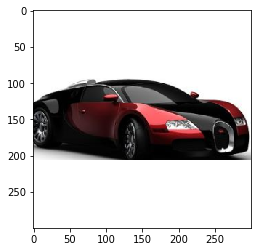

In [20]:
image_scaled = cv.resize(img_square, (300, 300))

plt.imshow(image_scaled)
plt.show()

## Rotating Images

It is sometimes useful to rotate images to feed them to your model. This increases the size of your training data and makes your model more resilient to subtle patterns that might exist within your base images.
 
For instance, in a popular fashion image dataset most boots are pointed one direction and sandals in the other. When the model attempts to identify a boot pointed in the wrong direction it will often predict 'sandal' based purely on the orientation of the object.
 
Flipping an image on the vertical and horizontal axis is simple enough. Just use the `flip` function.
 
Here is an example of flipping an image on the horizontal axis.

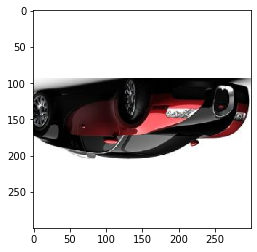

In [21]:
horizontal_img = cv.flip(image_scaled, 0)
plt.imshow(horizontal_img)
plt.show()

And now the vertial axis.

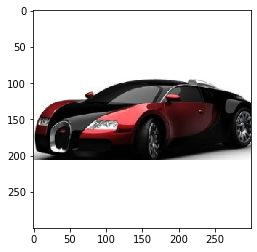

In [22]:
vertical_img = cv.flip(image_scaled, 1)
plt.imshow(vertical_img)
plt.show()

And finally both.

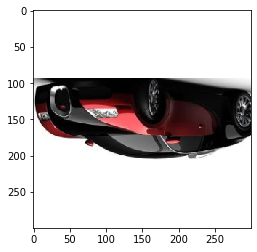

In [23]:
both = cv.flip(image_scaled, -1)
plt.imshow(both)
plt.show()

# Resources

* [OpenCV Documentation on Edge Detection](https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html)
* Canny Edge Detector: [Wikipedia](https://en.wikipedia.org/wiki/Canny_edge_detector), [OpenCV Documentation](https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html)

# Exercises

## Exercise 1

We have seen how to rotate an image on it's horizontal and vertical axis. This technique works well for increasing the size of your training set and the capabilities of your model, while also providing resiliency to biases that might be hidden in your data.
 
It is also possible to rotate an image by different angles.
 
Write OpenCV code to take our `image_scaled` image from above and rotate it so that the car is angled at 45-degrees. Do this for every corner of the squared image.
 
There should be 8 images in total. The order of the images isn't important, but the variety is. There should be one image for each case below:
 
1. Car pointed to the top-left corner of the image
1. Upside-down car pointed to the top-left corner of the image
1. Car pointed to the top-right corner of the image
1. Upside-down car pointed to the top-right corner of the image
1. Car pointed to the bottom-left corner of the image
1. Upside-down car pointed to the bottom-left corner of the image
1. Car pointed to the bottom-right corner of the image
1. Upside-down car pointed to the bottom-right corner of the image

Display the images using matplotlib.pyplot.
 
Hint: check out the `getRotationMatrix2D` and `warpAffine` methods.


### Student Solution

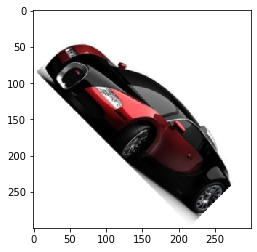

In [24]:
# Car pointed to the top-left corner of the image
horizontal_img = cv.flip(image_scaled, 0)
(height, width) = horizontal_img.shape[:2]
(cX, cY) = (width // 2, height // 2)
M = cv.getRotationMatrix2D((cX, cY), 135, 1.0)
top_left = cv.warpAffine(horizontal_img, M, (height, width),borderValue=(255,255,255))
plt.imshow(top_left)
plt.show()


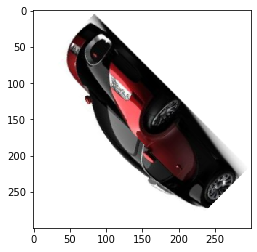

In [25]:
# Upside-down car pointed to the top-left corner of the image
(height, width) = image_scaled.shape[:2]
(cX, cY) = (width // 2, height // 2)
M = cv.getRotationMatrix2D((cX, cY), 135, 1.0)
top_left_flip = cv.warpAffine(image_scaled, M, (height, width),borderValue=(255,255,255))
plt.imshow(top_left_flip)
plt.show()

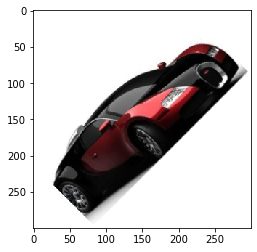

In [26]:
# Car pointed to the top-right corner of the image
(height, width) = image_scaled.shape[:2]
(cX, cY) = (width // 2, height // 2)
M = cv.getRotationMatrix2D((cX, cY), 45, 1.0)
top_right = cv.warpAffine(image_scaled, M, (height, width),borderValue=(255,255,255))
plt.imshow(top_right)
plt.show()

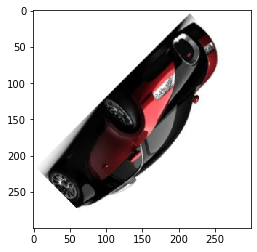

In [27]:
# Upside-down car pointed to the top-right corner of the image
horizontal_img = cv.flip(image_scaled, 0)
(height, width) = horizontal_img.shape[:2]
(cX, cY) = (width // 2, height // 2)
M = cv.getRotationMatrix2D((cX, cY), 45, 1.0)
top_right_flip = cv.warpAffine(horizontal_img, M, (height, width),borderValue=(255,255,255))
plt.imshow(top_right_flip)
plt.show()

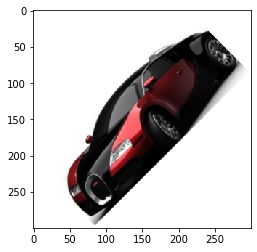

In [28]:
# Car pointed to the bottom-left corner of the image
horizontal_img = cv.flip(image_scaled, 0)
(height, width) = horizontal_img.shape[:2]
(cX, cY) = (width // 2, height // 2)
M = cv.getRotationMatrix2D((cX, cY), -135, 1.0)
bottom_left = cv.warpAffine(horizontal_img, M, (height, width),borderValue=(255,255,255))
plt.imshow(bottom_left)
plt.show()

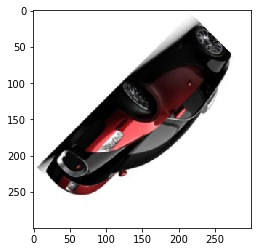

In [29]:
# Upside-down car pointed to the bottom-left corner of the image
(height, width) = image_scaled.shape[:2]
(cX, cY) = (width // 2, height // 2)
M = cv.getRotationMatrix2D((cX, cY), -135, 1.0)
bottom_left_flip = cv.warpAffine(image_scaled, M, (height, width),borderValue=(255,255,255))
plt.imshow(bottom_left_flip)
plt.show()

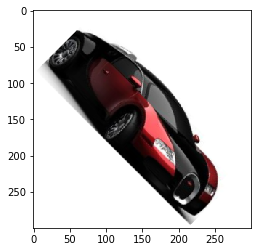

In [30]:
# Car pointed to the bottom-right corner of the image
(height, width) = image_scaled.shape[:2]
(cX, cY) = (width // 2, height // 2)
M = cv.getRotationMatrix2D((cX, cY), -45, 1.0)
bottom_right = cv.warpAffine(image_scaled, M, (height, width),borderValue=(255,255,255))
plt.imshow(bottom_right)
plt.show()

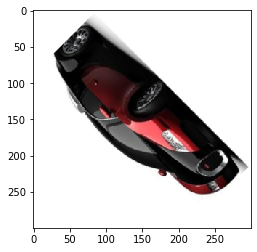

In [31]:
# Upside-down car pointed to the bottom-right corner of the image
horizontal_img = cv.flip(image_scaled, 0)
(height, width) = horizontal_img.shape[:2]
(cX, cY) = (width // 2, height // 2)
M = cv.getRotationMatrix2D((cX, cY), -45, 1.0)
bottom_right_flip = cv.warpAffine(horizontal_img, M, (height, width),borderValue=(255,255,255))
plt.imshow(bottom_right_flip)
plt.show()

## Exercise 2

Find the contours of the car image used in the example above and draw the contour lines to a blank image. Have the image background by black and the contour lines be white.

Note that the contours are lists of points that ou can use functions like [line](https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#line) to draw the contours.

### Student Solution

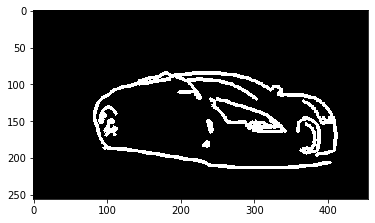

In [33]:
# Your answer goes here
import numpy as np
import pandas as pd
img_canny = cv.Canny(img_gray, 200, 200*2)

contours, _ = cv.findContours(
    img_canny, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

height,width = img_canny.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Using Line
for index in range(len(contours)):
  for i in range(len(contours[index])-1):
    for j in range(len(contours[index][i])):
      cv.line(blank_image,tuple(contours[index][i][j]),tuple(contours[index][i+1][j]),(255,255,255),3)

plt.imshow(blank_image)
plt.show()

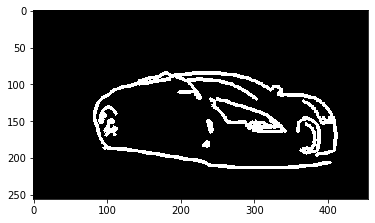

In [34]:
height,width = img_canny.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Using drawContours function 
cv.drawContours(blank_image, contours, -1, (255,255,255), 3)
plt.imshow(blank_image)
plt.show()